# User and product embeddings

We calculate user and product embeddings based on the training set, and evaluate the results on the unseen test set. We will evaluate the results by plotting the user and product similarity versus the review score.

In [1]:
import pandas as pd

df = pd.read_csv('/content/fine_food_reviews_with_embeddings_1k.csv')
df.head(1)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.0359942801296711, -0.02117965929210186, -0...."


In [2]:
print("Number of records:", df.shape)

unique_users = df['UserId'].nunique()
unique_products = df['ProductId'].nunique()

print("Number of unique users:", unique_users)
print("Number of unique products:", unique_products)

Number of records: (1000, 8)
Number of unique users: 708
Number of unique products: 868


We can see that most of the users and products appear within the 1k examples only once.

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from ast import literal_eval

df['babbage_similarity'] = df["embedding"].apply(literal_eval).apply(np.array)
df.head(1)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,babbage_similarity
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.0359942801296711, -0.02117965929210186, -0....","[0.0359942801296711, -0.02117965929210186, -0...."


In [4]:
prod_embeddings = df.groupby('ProductId').babbage_similarity.apply(np.mean)
print(len(prod_embeddings))

868


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(df, df.Score, test_size = 0.2, random_state=42)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((800, 9), (200, 9), (800,), (200,))

## 1. Calculate user and product embeddings



#### Approach 1: We calculate these embeddings simply by averaging all the reviews about the same product or written by the same user within the training set.



In [6]:
user_embeddings_method_1 = X_train.groupby('UserId').babbage_similarity.apply(np.mean)
print(len(user_embeddings_method_1))
user_embeddings_method_1.head()

577


UserId
A06364072LBY1F3ING9XN    [-0.027673892676830292, 0.0011768217664211988,...
A07895621XU7DHRAAPYJU    [0.022543027997016907, -0.013131280429661274, ...
A09539661HB8JHRFVRDC     [-0.008025233168154955, 0.025786804035305977, ...
A10QOESY9VJ9K            [-0.019612858071923256, -0.08770409971475601, ...
A111SHKHPDN8N            [0.012108179740607738, -0.039249029010534286, ...
Name: babbage_similarity, dtype: object

#### Approach 2: We calculate user embeddings by taking an weighted average over all their reviews about the same product.



In [7]:
# First, create a new column that stores the value of babbage_similarity divided by Score
X_train['babbage_similarity_per_score'] = X_train['babbage_similarity'] * X_train['Score'] / 5

# Now, calculate the user embeddings by grouping by 'UserId' and taking the mean of the new column
user_embeddings_method_2 = X_train.groupby('UserId').babbage_similarity_per_score.apply(np.mean)

print(len(user_embeddings_method_2))
user_embeddings_method_2.head()

577


UserId
A06364072LBY1F3ING9XN    [-0.027673892676830292, 0.0011768217664211988,...
A07895621XU7DHRAAPYJU    [0.022543027997016907, -0.013131280429661274, ...
A09539661HB8JHRFVRDC     [-0.006420186534523965, 0.02062944322824478, -...
A10QOESY9VJ9K            [-0.019612858071923256, -0.08770409971475601, ...
A111SHKHPDN8N            [0.012108179740607738, -0.039249029010534286, ...
Name: babbage_similarity_per_score, dtype: object

## 2. Evaluate the embeddings

To evaluate the recommendations, we look at the similarity of the user and product embeddings amongst the reviews in the unseen test set. We calculate the cosine distance between the user and product embeddings, which gives us a similarity score between 0 and 1. We then normalize the scores to be evenly split between 0 and 1, by calculating the percentile of the similarity score amongst all predicted scores.

In [8]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [9]:
# evaluate embeddings as recommendations on X_test
def evaluate_single_match(row, user_embeddings):
    user_id = row.UserId
    product_id = row.ProductId
    try:
        user_embedding = user_embeddings[user_id]
        product_embedding = prod_embeddings[product_id]
        similarity = cosine_similarity(user_embedding, product_embedding)
        return similarity
    except Exception as e:
        return np.nan

We group the cosine similarity scores by the review score, and plot the distribution of cosine similarity scores for each review score.

In [10]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

def evaluate_approach(X_test):
    correlation = X_test[['percentile_cosine_similarity', 'Score']].corr().values[0,1]
    print('Correlation between user & vector similarity percentile metric and review number of stars (score): %.2f%%' % (100*correlation))

    # boxplot of cosine similarity for each score
    X_test.boxplot(column='percentile_cosine_similarity', by='Score')
    plt.title('')
    plt.show()
    plt.close()

#### Evaluating Approach 1

Correlation between user & vector similarity percentile metric and review number of stars (score): 19.70%


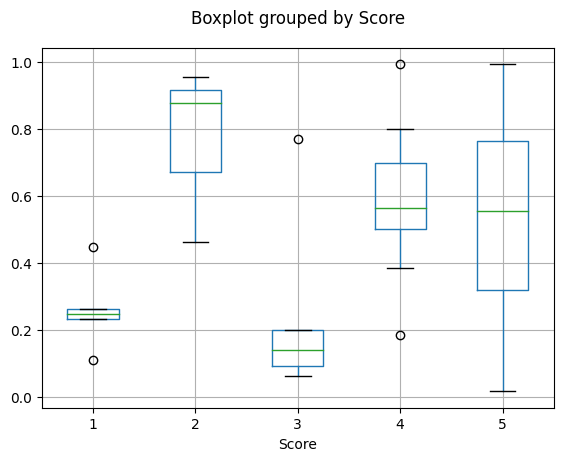

In [11]:
X_test_method_1 = X_test
X_test_method_1['cosine_similarity'] = X_test_method_1.apply(lambda row: evaluate_single_match(row, user_embeddings_method_1), axis=1)
X_test_method_1['percentile_cosine_similarity'] = X_test_method_1.cosine_similarity.rank(pct=True)

evaluate_approach(X_test_method_1)

#### Evaluating Approach 2

Correlation between user & vector similarity percentile metric and review number of stars (score): 18.19%


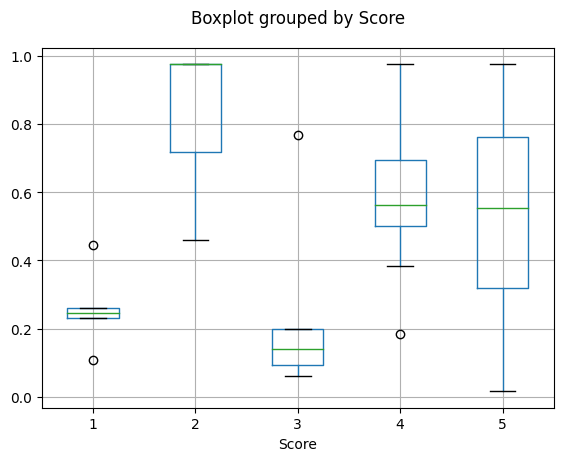

In [12]:
X_test_method_2 = X_test
X_test_method_2['cosine_similarity'] = X_test_method_2.apply(lambda row: evaluate_single_match(row, user_embeddings_method_2), axis=1)
X_test_method_2['percentile_cosine_similarity'] = X_test_method_2.cosine_similarity.rank(pct=True)

evaluate_approach(X_test_method_2)

#### Assessment by Claude AI

Given that both boxplots are based on the same test dataset with the same product embeddings, and the only difference is in the calculation of user embeddings used for cosine similarity, my final assessment is:

1. The overall distributions across the different score values are very similar between the two plots. This suggests that the change in user embedding calculation method did not significantly alter the overall patterns in the data.

2. The primary difference is the slight shift in the median value for score 2, where the second plot shows a higher median compared to the first. This could indicate that the new user embedding calculation improved the cosine similarity metric for a subset of data points with score 2.

3. The disappearance of the outlier for score 4 in the second plot is likely due to the change in user embedding calculation, which may have reduced some extreme values or brought them closer to the bulk of the distribution.

In summary, while the distributions are largely similar, the subtle changes in the median for score 2 and the absence of an outlier for score 4 suggest that the new user embedding calculation method has led to some improvement or refinement in the cosine similarity metric, especially for certain subsets of the data (scores 2 and 4).
However, since the overall patterns are not drastically different, it appears that the impact of the user embedding change is relatively minor, at least based on these particular boxplot visualizations of the data.

# [Extension] Multi-Class Classification

## Collaborative filtering

In [28]:
! pip install -qU scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [34]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming your DataFrame is named 'df'
# Columns: 'Score', 'user_id', 'product_id', 'embeddings'

# Step 1: Define a Reader object specifying the rating scale
reader = Reader(rating_scale=(1, 5))

# Step 2: Load the DataFrame into a Surprise Dataset
data = Dataset.load_from_df(df[['UserId', 'ProductId', 'Score']], reader)

# Step 3: Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Step 4: Define and train a collaborative filtering model (SVD)
model = SVD()
model.fit(trainset)

# Step 5: Predict ratings for the test set
predictions = model.test(testset)

# Step 6: Convert predictions to integer ratings
predicted_ratings = [round(pred.est) for pred in predictions]
print("predicted_ratings", predicted_ratings)

# Step 7: Extract actual ratings from test set
actual_ratings = [pred.r_ui for pred in predictions]
print("actual_ratings", actual_ratings)

# Step 8: Evaluate accuracy
accuracy = accuracy_score(actual_ratings, predicted_ratings)
print("Accuracy:", accuracy)

predicted_ratings [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4]
actual_ratings [5.0, 5.0, 5.0, 2.0, 5.0, 5.0, 5.0, 4.0, 1.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 3.0, 1.0, 3.0, 5.0, 5.0, 5.0, 5.0, 2.0, 5.0, 3.0, 5.0, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 4.0, 2.0, 5.0, 5.0, 1.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 2.0, 5.0, 1.0, 3.0, 5.0, 5.0, 5.0, 5.0, 

## Neural Networks

An experiment to see how does a feed forward neural network behave on test data when most of the users are new and unseen from train data.

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
"""
Guess all reviews to be just 5
"""
# Create a new series with the same length and all values set to 5
guessed_predictions = pd.Series(5, index=Y_test.index)
# Calculate classification accuracy
guessed_accuracy = accuracy_score(Y_test, guessed_predictions)
print('Classification Accuracy: %.2f%%' % (100*guessed_accuracy))

Classification Accuracy: 67.00%


In [16]:
# install required packages
! pip install -qU tensorflow
! pip install -qU keras_tuner

In [17]:
# import required packages
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split

In [18]:
df['embedding'][0]

'[0.0359942801296711, -0.02117965929210186, -0.02902456559240818, 0.009690768085420132, -0.015132874250411987, -0.05270250141620636, -0.016819609329104424, 0.05333900451660156, -0.02415531314909458, -0.019540661945939064, 0.04789689928293228, -0.01335066370666027, 0.016676396131515503, 0.005720576737076044, 0.018999634310603142, 0.0009124876232817769, 0.018999634310603142, 0.019333798438310623, 0.04032250493764877, 0.08128151297569275, 0.054134633392095566, 0.005442106164991856, -0.007701694034039974, 0.007347639184445143, 0.03145919367671013, -0.01172757986932993, -0.024664515629410744, 0.015562513843178749, 0.04153186455368996, -0.04016337916254997, -0.04496898129582405, -0.035898804664611816, -0.014798710122704506, -0.03354374319314957, 0.019858913496136665, 0.0374264158308506, 0.015920547768473625, -0.007343661040067673, 0.007252163253724575, 0.0019075218588113785, 0.005151701159775257, 0.03650348260998726, 0.04538270831108093, 0.028276674449443817, 0.025619272142648697, 0.01699464

In [19]:
import ast

def parse_embedding(embedding_str):
    """
    Parse the string representation of an embedding and convert it to a NumPy array.
    """
    return np.array(ast.literal_eval(embedding_str))

# Extract features and labels
input_features = np.array(df['embedding'].tolist()) #  convert the resulting Pandas Series to a list using tolist()
# Convert the 'embedding' column to a list of NumPy arrays
embeddings = df['embedding'].apply(parse_embedding).tolist()
# Convert the list of NumPy arrays to a single NumPy array
input_features = np.array(embeddings)

output_class = df['Score'].values
# Convert labels to categorical one-hot encoding
# output_class = keras.utils.to_categorical(output_class - 1)  # Adjust ratings to be zero-indexed

# Split data into training and testing sets
input_features_train, input_features_test, output_class_train, output_class_test = train_test_split(input_features, output_class, test_size=0.2, random_state=42)

In [20]:
print(input_features_train.shape)
print(input_features_train.dtype)

print(output_class_train.shape)
print(output_class_train.dtype)

(800, 1536)
float64
(800,)
int64


In [21]:
# Define the build model function
def build_model(hp):
    model = keras.Sequential()

    # Tune the number of units in the first dense layer
    units = hp.Int('units', min_value=16, max_value=128, step=16)
    model.add(keras.layers.Dense(units=units, activation='relu'))

    # Tune the number of dense layers and their units
    for i in range(hp.Int('num_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=4, max_value=32, step=4)
        model.add(keras.layers.Dense(units=units, activation='relu'))

    # Output layer with softmax activation for multi-class classification
    model.add(keras.layers.Dense(5, activation='softmax'))

    # Tune the optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    if optimizer == 'adam':
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    return model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Set this to a higher value for better hyperparameter tuning
    executions_per_trial=3,
    directory='my_dir',
    project_name='multi_class_classification'
)

# Perform the hyperparameter search
tuner.search(input_features_train, output_class_train,
             epochs=50,
             validation_data=(input_features_test, output_class_test))

Trial 5 Complete [00h 00m 29s]
val_accuracy: 0.13500000536441803

Best val_accuracy So Far: 0.13500000536441803
Total elapsed time: 00h 02m 41s


In [22]:
# Get the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(1)[0]
print(best_hps)

n_layers = best_hps.get('num_layers')
print(f'Number of hidden layers: {n_layers}')
for hyparam in [f'units_{i}' for i in range(n_layers)] + ['optimizer'] + ['learning_rate']:
    print(f'{hyparam}: {best_hps.get(hyparam)}')

Number of hidden layers: 1
units_0: 20
optimizer: adam
learning_rate: 0.0001372259330713521


In [23]:
# get the best model
best_model = tuner.get_best_models(1)[0]
print(best_model)

# display model structure
keras.utils.plot_model(best_model, 'best_model.png', show_shapes=True)

# show model summary
best_model.summary()

<Sequential name=sequential, built=True>


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (32, 16)                    │          24,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 20)                    │             340 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 5)                     │             105 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,037 (97.80 KB)

 Trainable params: 25,037 (97.80 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Build and train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
model.fit(
    input_features_train, output_class_train,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1199 - loss: nan
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1358 - loss: nan
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1503 - loss: nan 
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1218 - loss: nan 
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1579 - loss: nan 
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1475 - loss: nan 
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1515 - loss: nan 
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1278 - loss: nan 
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1283 - loss: nan 
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1497 - loss: nan 
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1346 - loss: nan 
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1302 - loss: nan 
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1243 - loss: nan 
Epoch 14/100


In [27]:
# evaluate the result
eval_result = model.evaluate(input_features_test, output_class_test)
print(f"test loss: {eval_result[0]}, test accuracy: {eval_result[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1298 - loss: nan
test loss: nan, test accuracy: 0.13500000536441803
